In [1]:
import datetime
import pandas as pd
import os
import json
import matplotlib as plt
import datetime as dt
import matplotlib.dates as dates

import elasticsearch
import elasticsearch.helpers

import concurrent

import sys
sys.path.append('/opt/2IMS40')

# Import files from current directory
from search_index import search_index
from es_client import es_client

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

es_client = es_client(local=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/elasticsearch/_sync/client/__init__.py:394: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [2]:
# Search all occurances of eventID 7 in the sysmon logs and round down their timestamps to whole minutes
df = search_index(es_client, "_exists_:Event.EventData.Image AND Event.System.EventID:7 ANDsource:sysmon.json").dropna(axis=1)
df['Event.System.TimeCreated.#attributes.SystemTime'] = pd.to_datetime(df['Event.System.TimeCreated.#attributes.SystemTime'])
df.set_index(df['Event.System.TimeCreated.#attributes.SystemTime'].dt.floor("min"), inplace=True)
print("Number of EventID 7 logs: " , len(df))

Number of EventID 7 logs:  585590


In [4]:
# A function that for each image counts the number of peaks and returns the highest number of peaks of similar height
# In addition to counting peaks of similar height the function also returns the time it takes for the first peak (of similar height) to occur
# Some variables are defined below to 

min_peak_size = 10 # Minimal number of logs per minute to count as peak
max_difference_in_peak_size = 0.02 # Maximum percentage difference between peaks to count as similar height

def count_peaks_of_similar_height(series):
    output = 0
    peak_heigt = 0
    time_until_first_peak = 0
    first_peak_found = False
    for i in range(len(series)):
        if series[i] > min_peak_size:
            peak_height = series[i]
            counter = 0
            for j in range(len(series)):
                if series[j] > peak_height*(1-max_difference_in_peak_size) and series[j] < peak_height*(1+max_difference_in_peak_size):
                    counter += 1
                    if not first_peak_found:
                        time_until_first_peak = i
                        first_peak_found = True
            if counter > output:
                output = counter   
    return output, time_until_first_peak

In [5]:
# Find all images that have 2 or more peaks of similar height

images_loaded_per_min = pd.crosstab(df.index, df["Event.EventData.Image"])
all_mins = pd.date_range(df.index.min(), df.index.max(), freq='min')
images_loaded_per_min = images_loaded_per_min.reindex(all_mins).fillna(0)
temp = []
for i in images_loaded_per_min.columns:
    temp.append(count_peaks_of_similar_height(images_loaded_per_min[i]))
images_with_multiple_peaks = pd.DataFrame(temp,index=images_loaded_per_min.columns)
images_with_multiple_peaks = images_with_multiple_peaks[images_with_multiple_peaks[0] > 1]

print("Number of images that have EventID 7 peaks of similar height: " , len(images_with_multiple_peaks))

Number of images that have EventID 7 peaks of similar height:  126


In [6]:
# Filter for all the images where a peak does not occur 10 days before another peak
# Note that in our implementation this means that there is no peak for the first 10 days, as the length of our data set is limited
# This filters for images that do not regularly load other images but suddenly start doing so
# Further filtering for only system utilities (in C:\windows) results in 4 executables

images_with_multiple_peaks = images_with_multiple_peaks[images_with_multiple_peaks[1] > 60*24*10]
images_with_multiple_peaks_time_filtered = images_with_multiple_peaks[images_with_multiple_peaks.index.str.contains("C??Windows")]

In [7]:
# Define malware related images and all images for calculation of statistics

all_unique_images = df["Event.EventData.Image"].str.lower().unique()

malware_images = set([
    'C:\\Users\\User\\Downloads\\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe'.lower(),
    'C:\\Users\\User\\AppData\\Roaming\\Microsoft\\Windows\\Start Menu\\Programs\\Startup\\Systdeeem.exe'.lower(),
    'C:\\Windows\\SysWOW64\\WindowsPowerShell\\v1.0\\powershell.exe'.lower(),
    'C:\\Windows\\System32\\conhost.exe'.lower(),
    'C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\RegSvcs.exe'.lower()
])
query_images = set(images_with_multiple_peaks_time_filtered.index.str.lower())

In [8]:
true_positives = len(malware_images.intersection(set(query_images)))
print("true_positives:", true_positives)
false_positives = len(set(query_images).difference(malware_images))
print("false_positives:", false_positives)
false_negatives = len(malware_images.difference(set(query_images)))
print("false_negatives:", false_negatives)
true_negatives = len(all_unique_images) - true_positives - false_positives - false_negatives #250
print("true_negatives:", true_negatives)

true_positives: 2
false_positives: 0
false_negatives: 3
true_negatives: 246


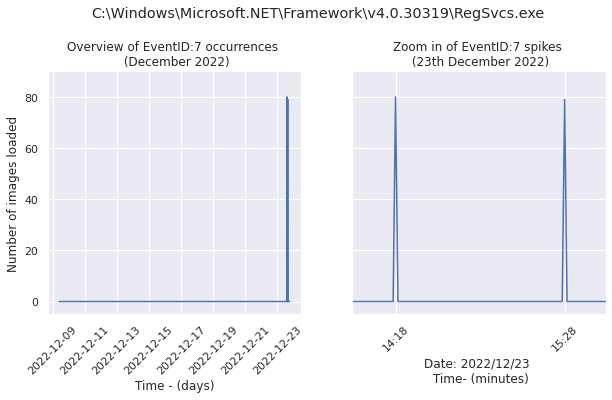

In [13]:
f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

ax.plot(images_loaded_per_min['C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\RegSvcs.exe'])
ax2.plot(images_loaded_per_min['C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\RegSvcs.exe'])

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45)
ax2.set_xlim(dates.date2num(dt.datetime(2022, 12, 23, 14, 0)), dates.date2num(dt.datetime(2022, 12, 23, 15, 45)))
ax.set_ylim(-5, 90)
ax2.set_ylim(-5, 90)
    
ax2.set_xticks([dates.date2num(dt.datetime(2022, 12, 23, 14, 18)), dates.date2num(dt.datetime(2022, 12, 23, 15, 28))])
ax2.set_xticklabels([str(dt.time(14, 18))[:-3], str(dt.time(15, 28))[:-3]])

ax.set_title("Overview of EventID:7 occurrences \n (December 2022)")
ax2.set_title("Zoom in of EventID:7 spikes \n (23th December 2022)")
ax.set_xlabel("Time - (days)")
ax.set_ylabel("Number of images loaded")
ax2.set_xlabel("Date: 2022/12/23 \n Time- (minutes)")

f.suptitle('C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\RegSvcs.exe')
plt.subplots_adjust(top=0.8)


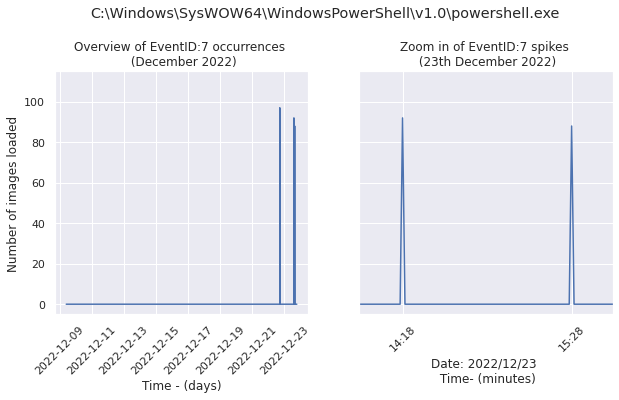

In [15]:
f2,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

ax.plot(images_loaded_per_min['C:\\Windows\\SysWOW64\\WindowsPowerShell\\v1.0\\powershell.exe'])
ax2.plot(images_loaded_per_min['C:\\Windows\\SysWOW64\\WindowsPowerShell\\v1.0\\powershell.exe'])

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45)
ax2.set_xlim(dates.date2num(dt.datetime(2022, 12, 23, 14, 0)), dates.date2num(dt.datetime(2022, 12, 23, 15, 45)))
ax.set_ylim(-5, 115)
ax2.set_ylim(-5, 115)
    
ax2.set_xticks([dates.date2num(dt.datetime(2022, 12, 23, 14, 18)), dates.date2num(dt.datetime(2022, 12, 23, 15, 28))])
ax2.set_xticklabels([str(dt.time(14, 18))[:-3], str(dt.time(15, 28))[:-3]])

ax.set_title("Overview of EventID:7 occurrences \n (December 2022)")
ax2.set_title("Zoom in of EventID:7 spikes \n (23th December 2022)")
ax.set_xlabel("Time - (days)")
ax.set_ylabel("Number of images loaded")
ax2.set_xlabel("Date: 2022/12/23 \n Time- (minutes)")

f2.suptitle('C:\\Windows\\SysWOW64\\WindowsPowerShell\\v1.0\\powershell.exe')
plt.subplots_adjust(top=0.8)

In [16]:
accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
FPR = false_positives / (false_positives + true_negatives) # false positive rate
TNR = true_negatives / (false_positives + true_negatives)
F1_score = 2 * precision * recall / (precision + recall)

print("Accuracy            = " + "{0:.3f}".format(accuracy))
print("Precision           = " + "{0:.3f}".format(precision))
print("Recall              = " + "{0:.3f}".format(recall))
print("False Positive Rate = " + "{0:.3f}".format(FPR))
print("True  Negative Rate = " + "{0:.3f}".format(TNR))
print("F1-score            = " + "{0:.3f}".format(F1_score))

Accuracy            = 0.988
Precision           = 1.000
Recall              = 0.400
False Positive Rate = 0.000
True  Negative Rate = 1.000
F1-score            = 0.571
